## Check how charge throughput is affected by save_as_cycles

In [1]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2

In [2]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

BasicPath =  os.path.expanduser("~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * # directly do this for HPC

In [3]:
model = pb.lithium_ion.DFN()
T_All = [25]
Para_All = []
for T in T_All:
    param = pb.ParameterValues("OKane2023")
    para_dict = {
        "Negative electrode diffusivity [m2.s-1]":3.3e-14,
        "Positive electrode diffusivity [m2.s-1]":4e-15,
    }
    for key, value in para_dict.items():
        param.update({key: value})
    param.update({'Ambient temperature [K]': T+273.15})
    Para_All.append(param)
V_max = 4.2;        V_min = 2.5; Update_Cycles = [1,10]
discharge_time_mins = 0.15* 60 * 4.86491/5
charge_time_mins = 0.5* 60 * 4.86491/5
exp_AGE_text = [ (
    f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
    f"Charge at 0.3C for {charge_time_mins} minutes or until {V_max}V", 
    ) ] 
Experiment_Long   = pb.Experiment( exp_AGE_text * 10  )
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 20,  # positive particle
}


In [4]:
# CasadiSolver
Sol = []
for update_Cycle in Update_Cycles:
    sim = pb.Simulation(
        model, 
        experiment=Experiment_Long,
        parameter_values=param,
        solver=pb.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts, )
    sol = sim.solve(
        calc_esoh=False,
        save_at_cycles = update_Cycle,)
    Sol.append(sol)

14.381651547421372 14.381651547421345
19.140994331531758 19.140994331531775


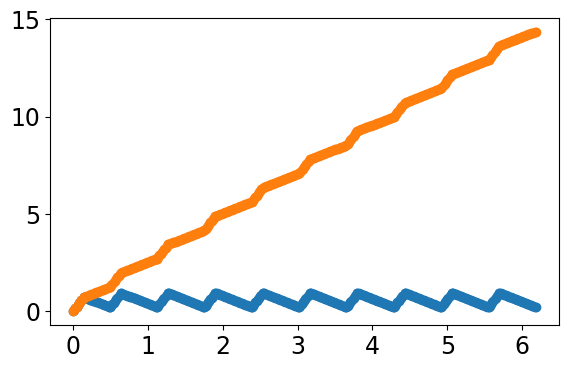

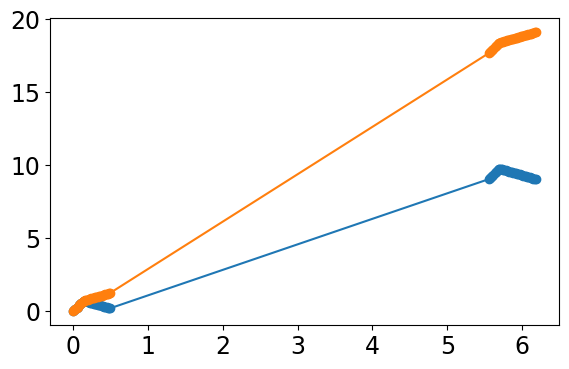

In [5]:
def Plot_sol(sol):
    # step-1: get and plot discharge capacity vs throughput capacity 
    fig, axs = plt.subplots( figsize=(6,4),tight_layout=True) 
    axs.plot(sol["Time [h]"].entries,sol["Discharge capacity [A.h]"].entries,'-o')
    axs.plot(sol["Time [h]"].entries,sol["Throughput capacity [A.h]"].entries-sol["Throughput capacity [A.h]"].entries[0],'-o')
    thr_cap_1 = sol["Throughput capacity [A.h]"].entries[-1]-sol["Throughput capacity [A.h]"].entries[0]
    thr_cap_2 = np.trapz(abs(sol["Current [A]"].entries), sol["Time [h]"].entries) # in A.h
    print(thr_cap_1,thr_cap_2)
    return thr_cap_1,thr_cap_2
thr_cap_1,thr_cap_2 = Plot_sol(Sol[0])
thr_cap_3,thr_cap_4 = Plot_sol(Sol[1])